# Исследование объявлений о продаже квартир

## Описание проекта

Сервис Яндекс.Недвижимость размещает объявления о продаже квартир. По его заказу нужно проанализировать рынок недвижимости в Санкт-Петербурге и соседних населённых пунктых за несколько лет и определить влияние различных параметров на цену квартир. В будущем это позволит 
построить автоматизированную систему для отслеживания аномалий и мошеннической деятельности.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## <a name="0"> Структура исследования </a>

- [Загрузка данных и первичное ознакомление](#step1)
- [Предобработка данных](#step2)
    - [Обработка пропусков](#step21)
    - [Обработка типов данных](#step22)
    - [Обработка артефактов](#step23)
    - [Удаление скрытых дублей](#step24)
- [Добавление новых столбцов в таблицу](#step3)
- [Исследовательский анализ данных](#step4)
    - [Площадь](#step41)
    - [Цена](#step42)
    - [Цена кв. м](#step43)
    - [Число комнат](#step44)
    - [Высота потолков](#step45)
    - [Время продажи](#step46)
    - [Влияние площади на цену](#step47)
    - [Влияние числа комнат на цену](#step48)
    - [Влияние удалённости от центра на цену](#step49)
    - [Влияние типа этажа на цену](#step410)
    - [Влияние дня недели размещения на цену](#step411)
    - [Влияние месяца размещения на цену](#step412)
    - [Влияние года размещения на цену](#step413)
    - [10 населённых пунктов с наибольшим числом объявлений](#step414)
    - [Определение центра Санкт-Петербурга](#step415)
    - [Анализ квартир в центре Санкт-Петербурга](#step416)
- [Общий вывод](#step5)

## <a name="step1"> Загрузка данных и первичное ознакомление </a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import warnings
warnings.simplefilter('ignore')

Откроем файл с данными:

In [2]:
df = pd.read_csv('/Users/polzovatel/Desktop/Projects/Real_estate_analysis/real_estate_data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Часть столбцов были вырезаны при отображении таблицы. Сделаем так, чтобы в будущем отображались все столбцы:

In [3]:
pd.set_option('display.max_columns', None)

Выведем основную информацию о таблице:

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Описание данных:
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- last_price — цена на момент снятия с публикации
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)
- total_images — число фотографий квартиры в объявлении

Пояснение: апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания.

В таблице 22 столбца и 23 699 строк. Данные 4 типов: bool (2 столбца), float64 (14 столбцов), int64 (3 столбца), object (3 столбца). 

Можно заметить, что в некоторых столбцах есть пропуски. Причем столбцы с пропусками можно разделить на два типа:
- где пользователь не указал значение:
  - ceiling_height;
  - floors_total;
  - living_area;
  - is_apartment;
  - kitchen_area;
  - balcony;
- где значения должны заноситься автоматически исходя из геолокации объявлений, но по какой-то причине отсутствуют:
  - locality_name;
  - airports_nearest;
  - cityCenters_nearest;
  - parks_nearest;
  - ponds_nearest.

Посмотрим на долю пропусков для каждого столбца. Построим наглядную гистограмму.

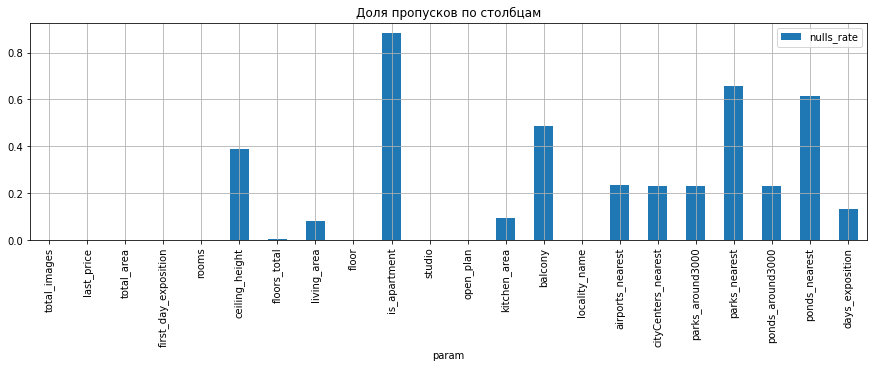

In [5]:
rows_count = len(df) # посчитаем количество строк в таблице
data = {} # создадим пустой словарь
for column in df.columns: # для каждого столбца в таблице
    nulls_count = df[column].isnull().sum() # посчитаем количество пропусков
    rate = nulls_count / rows_count # найдём долю пропусков в столбце
    data[column] = [rate] # положим в словарь название столбца и долю пропусков в нём
df_nulls_rate = pd.DataFrame(data) # из полученного словаря создадим таблицу с долей пропусков для каждого столбца
df_nulls_rate = df_nulls_rate.T # транспонируем таблицу
df_nulls_rate = df_nulls_rate.reset_index() # обновим индексы, теперь в таблице два столбца: названия столбцов в df и доля пропусков
df_nulls_rate.columns = ['param', 'nulls_rate'] # дадим столбцам соответствующие названия
df_nulls_rate.plot(title='Доля пропусков по столбцам', x='param', y='nulls_rate', figsize=(15, 4), kind='bar', grid=True) # построим гистограмму
plt.show()

На гистограмме можно увидеть, что столбец is_apartment практически полностью пустой. Больше 60% данных в parks_nearest и ponds_nearest пропущены. Примерно 50% - в balcony, 40% - в ceiling_height. Чуть больше 20% - в столбцах airports_nearest, cityCenters_nearest, parks_around3000 и ponds_around3000. В остальных столбцах пропусков меньше либо их вообще нет.

Чуть ранее, применив метод info() к таблице, мы могли заметить, что в некоторых столбцах типы данных не соотвествуют ожидаемым. Их можно исправить на более подходящие: 
- в столбце balcony правильнее использовать данные типа int, так как количество балконов не может быть дробным числом. 
- в столбцах airports_nearest, cityCenters_nearest, ponds_nearest и parks_nearest также правильнее использовать данные типа int, так как достаточно целых значений расстояния в метрах.
- в столбце last_price досточно целых значений цены в рублях.
- в столбце first_day_exposition данные должны быть типа datetime.
- в столбце floors_total - этажи могут быть только целыми значениями.
- в столбце is_apartment значения должны быть типа bool.
- в столбцах parks_around3000 и ponds_around3000 должны быть целые числа, так как количество парков и прудов не может быть дробным.
- столбце days_exposition должен содержать целые числа.

Подробнее изучим пропуски и типы данных далее в исследовании, а пока посмотрим на статистические параметры таблицы.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Можно выделить следующие необычные значения:
- минимальное значение last_price - 12 190. Для квартиры это нереалистично низкая цена. Надо будет внимательнее изучить этот столбцец, посмотреть сколько таких низких значений и как их можно исправить. Возможно в данных просто опечатка и не хватает нескольких нулей.
- минимальное значение ceiling_height - 1 максимальное значение - 100. Высота потолков не может быть один метр и сто метров. Этот параметр вносят пользователи сайта и скорее всего они опечатались;
- максимальное значение floors_total - 60. В Санкт-Петербурге нет жилых зданий с таким количеством этажей. Самое высокое жилое здание - ЖК "Князь Александр Невский", но в нём только 37 этажей. В Лахта-центре 88 этажей, но там нет квартир и апартаментов. Поэтому этажность домов в данных также надо будет внимательно изучить.
- минимальное значение airports_nearest - 0. Скорее всего в данных ошибка.
- максимальное значение total_area - 900 кв. м - очень большое значение. Проверим, сколько объявлений с площадью более 300 кв. м. Если немного, то лучше сразу от них избавиться.
- максимальное значение rooms - 19 комнат - очень большое число, явный выброс. Проверим, сколько объявлений с числом комнат больше 7.

Посмотрим на статистические параметры нечисловых данных в таблице:

In [7]:
df.describe(include='O')

,first_day_exposition,is_apartment,locality_name
count,23699,2775,23650
unique,1491,2,364
top,2018-02-01T00:00:00,False,Санкт-Петербург
freq,368,2725,15721


Можно сделать вывод, что наиболее часто встречаются объявления, которые были размещены в начале 2018 года. Надо будет изучить временной диапазон публикации объявлений в датасете, чтобы понять, публикация от начала 2018 - это давно висящее объявление или нет. Также видно, что больше всего квартир в продаже в Санкт-Петербурге.

Проверим, есть ли в таблице строки-дубли:

In [8]:
df.duplicated().sum()

0

Строк-дублей не обнаружено.

Проверим наличие скрытых дублей в столбцах, содержащих текстовые данные. Взглянем на уникальные значения в столбце locality_name. 

In [9]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Посчитаем количество уникальных:

In [10]:
len(df['locality_name'].unique())

365

Всего 365 значений. Бросается в глаза, что где-то записано "поселок" через "е", а где-то "посёлок" через "ё". Видимо в словаре на портале встречаются такие задвоения названий. Надо сообщить инженерам, чтобы исправили ошибку. А в нашей таблице надо будет все "ё" заменить на "е".

Также названия населенных пунктов теоретически могут быть записаны по-разному - где-то просто "посёлок", где-то "посёлок городского типа" и т.п. Чтобы исключить все возможные задвоения, нужно будет отбросить типы населённых пунктов и оставить только непосредственно их названия.

Проведём работу по исключению скрытых дублей далее в исследовании - в шаге по предобработке данных ([тут](#step24)).

#### Вывод

В данных были замечены пропуски, неверные типы данных, артефакты и скрытые дубли. Чтобы исправить ошибки, нужно будет провести предобработку данных. Так мы исключим или минимизируем их влияние на выводы исследования.

[В начало](#0)

## <a name="step2"> Предобработка данных </a>

### <a name="step21"> Обработка пропусков </a>

Для начала разберёмся с пропусками в данных. Попробуем понять их логику. Перечислем еще раз все столбцы с пропущенными значениями и для каждого выдвенем предположение, с чем связаны пропуски.

#### - столбцы, где пользователь не указал значение: 

Пользователем может быть как собственник жилья, так и агент, который продаёт объект. Обычно собственнику жилья известно больше информации, чем агенту. Поэтому, вероятно, основная масса пропусков связана с тем, что агенты просто не стали уточнять у собственников и заполнять необязательные параметры в объявлениях. Другая возможная причина пропусков - пользователь просто случайно пропустил параметр при заполнении.

Столбцы:
  - ceiling_height - либо не знает, либо случайно пропустил;
  - floors_total - либо не знает, либо случайно пропустил (например, агент забыл уточнить у собственника этажность дома);
  - living_area - либо не знает, либо случайно пропустил (некоторые не понимают смысла понятия "жилая площадь" и не заполняют параметр);
  - is_apartment - либо не знает, либо случайно пропустил;
  - kitchen_area - либо не знает, либо случайно пропустил. Также можно предположить, что этот параметр пользователь не заполнял для студий либо квартир с 0 комнат. Надо проверить, связаны ли пропуски в kitchen_area с этими параметрами;
  - balcony - если человек не указал число балконов, то скорее всего, их нет. Такие пропуски можно заменить на 0;
  
#### - столбцы, где значения должны заноситься автоматически, но по какой-то причине отсутствуют:

Все эти данные объединяет то, что они относятся к геолокации объекта. Если пользователь не указал геолокацию, то у объявления будут пропуски во всех этих столбцах. Тогда количество пропусков в таблице по всем этим столбцам будет одинаковым. Но это не так. Другой причиной пропусков может быть технический сбой при записи данных в БД или выгрузке оттуда. Об этой проблеме надо сообщить инженерам БД.

Столбцы:
  - locality_name; 
  - airports_nearest;
  - cityCenters_nearest;
  - parks_nearest;
  - ponds_nearest.

Заполним пропуски, где мы установили логику их появления.

#### Заполнение пропусков в столбце balcony

Пропущенные значения в столбце balcony, как мы указали ранее, заполним нулями:

In [11]:
df['balcony'] = df['balcony'].fillna(0)

Проверим, что пропусков не осталось:

In [12]:
df['balcony'].isnull().sum()

0

#### Заполнение пропусков в столбце kitchen_area

Теперь проверим нашу гипотезу, что пропуски в столбце kitchen_area связаны с тем, что объекты являются либо студиями, либо в них 0 комнат. Выведем значения и их количества в столбце studio и rooms, где в столбце kitchen_area пропущены значения.

In [13]:
df.query('kitchen_area.isnull()')['rooms'].value_counts()

1    834
2    654
3    434
0    197
4     99
5     41
6      8
7      7
8      3
9      1
Name: rooms, dtype: int64

In [14]:
df.query('kitchen_area.isnull()')['studio'].value_counts()

False    2129
True      149
Name: studio, dtype: int64

Можно отметить, что в объявлениях, где пропущены значения kitchen_area, встречается и разнообразное количество комнат, и студии, и не студии. Поэтому сказать, что пропуски связаны с параметрами rooms и studio нельзя. Вероятно, что пропуски вызваны другой причиной - например, пользователь не знает квадратуру кухни отдельно. Пока оставим пропуски.

#### Заполнение пропусков в объявлениях на основе триангуляции местоположения

Помимо воссоздания данных на основе предположений и догадок можно применить триангуляцию местоположения: найти объявления, где совпадают расстояния до трёх точек (например, аэропорта, центра города и пруда). Это будет означать, что данные объявления относятся к одному дому. И тогда можно попробовать заполнить пропуски в одних объявлениях данными из других объявлений. Этот способ может подойти для воссоздания данных в столбцах floors_total, is_apartment, locality_name, parks_around3000, parks_nearest, ponds_around3000. Попробуем применить этот способ.

Найдём расстояние до центра города, которое чаще всего встречается в объявлениях:

In [15]:
df['cityCenters_nearest'].value_counts()

8460.0     61
20802.0    32
10720.0    30
8434.0     27
20444.0    27
           ..
5278.0      1
11575.0     1
3205.0      1
12747.0     1
4234.0      1
Name: cityCenters_nearest, Length: 7642, dtype: int64

В 61 объявлении расстояние до центра города составляет 8460 м. Это могут быть разные дома, расположенные на одинаковом расстоянии от центра. Посмотрим, какие у этих объявлений расстояния до аэропортов:

In [16]:
df.query('cityCenters_nearest == 8460.0')['airports_nearest'].value_counts()

37434.0    61
Name: airports_nearest, dtype: int64

У всех объявлений одинаковое расстояние до аэропортов - 37 434 м. Это означает, что все эти объявления находятся на одинаковом расстоянии от центра города и одинаковом расстоянии от аэропорта. Такое возможно только, если они относятся к одному или двум домам. Чтобы окончательно установить, находятся ли все эти квартиры в одном доме, нужно проверить расстояние до третьей точки - используем расстояние до ближайшего пруда.

Прим.: конечно, ближайшие пруды могут оказаться на совпадающем расстоянии до двух домов. Но вероятность такого очень низкая, мы пренебрежём ею.

In [17]:
df.query('cityCenters_nearest == 8460.0 and airports_nearest == 37434.0')['ponds_nearest'].value_counts()

427.0    61
Name: ponds_nearest, dtype: int64

У всех объявлений одинаковое расстояние до ближайшего пруда - 427 м. Это означает, что все эти объявления относятся к одному дому.

Теперь взглянем, какие данные пропущенны для этих объявлений:

In [18]:
df.query('cityCenters_nearest == 8460.0').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 177 to 23516
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          61 non-null     int64  
 1   last_price            61 non-null     float64
 2   total_area            61 non-null     float64
 3   first_day_exposition  61 non-null     object 
 4   rooms                 61 non-null     int64  
 5   ceiling_height        42 non-null     float64
 6   floors_total          61 non-null     float64
 7   living_area           56 non-null     float64
 8   floor                 61 non-null     int64  
 9   is_apartment          1 non-null      object 
 10  studio                61 non-null     bool   
 11  open_plan             61 non-null     bool   
 12  kitchen_area          59 non-null     float64
 13  balcony               61 non-null     float64
 14  locality_name         61 non-null     object 
 15  airports_nearest    

Можно заметить, что очень много пропусков в столбце is_apartment. Выясним, какое значение в объявлении, где этот параметр заполнен:

In [19]:
df.query('cityCenters_nearest == 8460.0')['is_apartment'].value_counts()

False    1
Name: is_apartment, dtype: int64

Один из пользователей указал, что объект не является апартаментом. Скорее всего это означает, что дом состоит из квартир и пропуски во всех остальных объявлениях можно также заполнить False. Сделаем это:

In [20]:
df['is_apartment'] = df['is_apartment'].where(df['cityCenters_nearest'] != 8460.0, False) 

Проверим, что столбец is_apartment заполнился для этих объявлений:

In [21]:
df.query('cityCenters_nearest == 8460.0')['is_apartment'].value_counts()

False    61
Name: is_apartment, dtype: int64

Теперь для всех объявлений из этого дома отмечено, что они не являются апартаментами.

Применение триангуляции местоположения для восстановления данных возможно, но требует очень много времени - параметров у домов много и самих домов много. Для нашего исследования такой способ может быть избыточным. 

#### Заполнение пропусков в других столбцах

Для других столбцов нет подходящих значений на замену. В этом случае правильно оставить эти значения пустыми. Отсутствие значения - тоже важный сигнал, который не нужно прятать.

[В начало](#0)

### <a name="step22"> Обработка типов данных </a>

Мы установили следующие проблемы в типах данных:
- в столбце balcony правильнее использовать данные типа int, так как количество балконов не может быть дробным числом. 
- в столбцах airports_nearest, cityCenters_nearest, ponds_nearest и parks_nearest также правильнее использовать данные типа int, так как достаточно целых значений расстояния в метрах.
- в столбце last_price досточно целых значений цены в рублях.
- в столбце first_day_exposition данные должны быть типа datetime.
- в столбце floors_total - этажи могут быть только целыми значениями.
- в столбце is_apartment значения должны быть типа bool.
- в столбцах parks_around3000 и ponds_around3000 должны быть целые числа, так как количество парков и прудов не может быть дробным.
- столбце days_exposition должен содержать целые числа.

Посчитаем объём занимаемой таблицей памяти:

In [22]:
memory_before = df.memory_usage(deep=True).sum()
memory_before

8443836

Заменим тип данных в столбцах balcony, last_price и total_area с float на int:

In [23]:
df['balcony'] = df['balcony'].astype('int')
df['last_price'] = df['last_price'].astype('int')
df['total_area'] = df['total_area'].astype('int')

Заменим тип данных в столбце first_day_exposition на datetime:

In [24]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим, изменились ли типы данных в этих столбцах:

In [25]:
df['balcony'].dtypes

dtype('int64')

In [26]:
print(df['balcony'].dtypes)
print(df['last_price'].dtypes)
print(df['total_area'].dtypes)
print(df['first_day_exposition'].dtypes)

int64
int64
int64
datetime64[ns]


Да, типы данных в этих столбцах изменились.

Так как заменить тип данных можно только в столбцах без пропусков, то в других столбцах не получится это сделать. Пока оставим их такими, какие они есть. 

Посчитаем объём занимаемой таблицей памяти еще раз:

In [27]:
df.memory_usage(deep=True).sum()

6832304

Объём уменьшился. Попробуем еще оптимизировать типы данных.

Выведем макс. и мин. ограничения по размеру значений для разных типов целых чисел:

In [28]:
int_types = ["uint8", "int8", "uint16", 'int16', 'uint32', 'int32']
for number_type in int_types:
    print(np.iinfo(number_type))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for uint16
---------------------------------------------------------------
min = 0
max = 65535
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for uint32
---------------------------------------------------------------
min = 0
max = 4294967295
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -

Исходя из ограничений подберём подходящий тип данных для столбцов, чтобы уменьшить объём занимаемой ими памяти:

In [29]:
df['balcony'] = df['balcony'].astype('uint8') # так как в этом столбце только положительные и небольшие значения
df['total_area'] = df['total_area'].astype('uint16') # так как в этом столбце только положительные, но больше макс для uint8
df['last_price'] = df['last_price'].astype('uint32') # так как в этом столбце только положительные, но больше макс для uint16
df['total_images'] = df['total_images'].astype('uint8')
df['rooms'] = df['rooms'].astype('uint8')
df['floor'] = df['floor'].astype('uint8')

Снова посчитаем объём занимаемой таблицей памяти:

In [30]:
df.memory_usage(deep=True).sum()

5931742

Объём памяти уменьшился.

Поскольку в других столбцах с цифрами встречаются пропуски, то их тип отображается как float. Это связано с тем, что значения NaN имеют такой тип. Тип данных таких столбцов можно поменять с дробного на целочисленный, применив специальный тип Int (с заглавной "I"):

In [31]:
df['floors_total'] = df['floors_total'].astype('Int8')
df['airports_nearest'] = df['airports_nearest'].astype('Int32')
df['parks_nearest'] = df['parks_nearest'].astype('Int32')
df['ponds_nearest'] = df['ponds_nearest'].astype('Int32')

Замерим объём памяти:

In [32]:
memory_after = df.memory_usage(deep=True).sum()
memory_after

5576257

In [33]:
(memory_before - memory_after) / memory_before

0.3396061932041314

За счёт всех преобразований типов данных в столбцах нам удалось уменьшить объём занимаемой памяти с 8443836 до 5505160 байт - на 35%.

[В начало](#0)

### <a name="step23"> Обработка артефактов </a>

Ранее мы выделили следующие артефакты:
- минимальное значение last_price - 12 190. Для квартиры это нереалистично низкая цена. Надо будет внимательнее изучить этот столбцец, посмотреть сколько таких низких значений и как их можно исправить. Возможно в данных просто опечатка и не хватает нескольких нулей.
- минимальное значение ceiling_height - 1 максимальное значение - 100. Высота потолков не может быть один метр и сто метров. Этот параметр вносят пользователи сайта и скорее всего они опечатались;
- максимальное значение floors_total - 60. В Санкт-Петербурге нет жилых зданий с таким количеством этажей. Самое высокое жилое здание - ЖК "Князь Александр Невский", но в нём только 37 этажей. В Лахта-центре 88 этажей, но там нет квартир и апартаментов. Поэтому этажность домов в данных также надо будет внимательно изучить.
- минимальное значение airports_nearest - 0. Скорее всего в данных ошибка.
- максимальное значение total_area - 900 кв. м - очень большое значение. Проверим, сколько объявлений с площадью более 300 кв. м. Если немного, то лучше сразу от них избавиться. 
- максимальное значение rooms - 19 комнат - очень большое число, явный выброс. Проверим, сколько объявлений с числом комнат больше 7.

Изучим столбец last_price, выведем цены в порядке возрастания:

In [34]:
df['last_price'].sort_values().head()

8793      12190
17456    430000
14911    430000
16274    440000
17676    450000
Name: last_price, dtype: uint32

Всего одно объявление с нереалистично низкой ценой. Посмотрим на него внимательно. Возможно данные в других столбцах подскажут нам, как можно исправить ошибку.

In [35]:
df.loc[8793]

total_images                              7
last_price                            12190
total_area                              109
first_day_exposition    2019-03-20 00:00:00
rooms                                     2
ceiling_height                         2.75
floors_total                             25
living_area                           32.00
floor                                    25
is_apartment                            NaN
studio                                False
open_plan                             False
kitchen_area                          40.50
balcony                                   0
locality_name               Санкт-Петербург
airports_nearest                      36421
cityCenters_nearest                 9176.00
parks_around3000                       1.00
parks_nearest                           805
ponds_around3000                       0.00
ponds_nearest                          <NA>
days_exposition                        8.00
Name: 8793, dtype: object

Попробуем посмотреть на медианную цену квартиры в Санкт-Петербурге с примерно такой же площадью и таким же расстоянием от центра:

In [36]:
df.query('104 < total_area < 114 and locality_name == "Санкт-Петербург" and 8000 < cityCenters_nearest <10000')['last_price'].median()

12650000.0

Цена в нашем объявлении 12 190, а медианная цена для аналогичной квартиры - 12 650 000. Скорее всего в нашем объявлении опечатка - не хватает 3 нулей. Исправим ошибку:

In [37]:
df.loc[8793, 'last_price'] = df.loc[8793, 'last_price'] * 1000

Проверим, что опечатка исправлена:

In [38]:
df.loc[8793, 'last_price']

12190000

Теперь проверим артефакты в данных высоты потолков. Будем считать, что потолки не могут быть ниже 2,5 м (согласно ГОСТу) и врядли они будут выше 8 метров. Всё, что не попадает в этот диапазон - артефакты. Найдём их.

Посчитаем количество объявлений, где высота потолков ниже 2,5 м:

In [39]:
len(df.query('ceiling_height < 2.5'))

73

Достаточно большое число. Если просто удалить эти строки, то можно потерять важную информацию в других столбцах. Посчитаем, какую долю эти строки составляют от общего числа строк в таблице:

In [40]:
len(df.query('ceiling_height < 2.5')) / len(df)

0.0030802987467825646

Около 0,3%. Так как доля небольшая, то удаление этих строк не окажет существенное влияние на дальнейший анализ данных. Зато сведёт к нулю риск случайно использовать их в анализе. Удалим строки:

In [41]:
df = df.drop(df.query('ceiling_height < 2.5').index)

Выведем количество объявлений с высотой потолков более 8 м:

In [42]:
df.query('ceiling_height > 8')['ceiling_height'].value_counts()

27.0     8
25.0     7
32.0     2
14.0     1
20.0     1
24.0     1
27.5     1
10.3     1
8.3      1
22.6     1
26.0     1
100.0    1
Name: ceiling_height, dtype: int64

В объявлениях, где высота оказалась больше 8 метров, часто встречаются значения в диапазоне 25-32 м. Скорее всего при заполнении параметра пользователь опечатался и неправильно поставил разделитель. Если значения разделить на 10, то будет похоже на реалистичное значение. Напишем для этого функцию и применим её к столбцу.

In [43]:
def ceiling_height_correction(ceiling_height):
    if 25 <= ceiling_height <=32:
        return ceiling_height / 10
    return ceiling_height

In [44]:
df['ceiling_height'] = df['ceiling_height'].apply(ceiling_height_correction)

Проверим, что функция сработала:

In [45]:
df.query('ceiling_height > 8')['ceiling_height'].value_counts()

14.0     1
20.0     1
10.3     1
8.3      1
24.0     1
22.6     1
100.0    1
Name: ceiling_height, dtype: int64

Осталось всего 7 объявлений. Их можно удалить, не боясь, что это внесёт искажения в наши данные. 

In [46]:
df = df.drop(df.query('ceiling_height > 8').index)

Теперь проверим артефакты в этажности домов. Как мы помним, самое высокое жилое здание в Санкт-Петербурге и области имеет 37 этажей. Найдём все выбивающиеся объявления.

In [47]:
df.query('floors_total > 37')['floors_total'].value_counts()

60    1
52    1
Name: floors_total, dtype: Int64

Всего 2 объявления, удалим их:

In [48]:
df = df.drop(df.query('floors_total > 37').index)

Теперь проверим все объявления, где указано расстояние до аэропорта менее 50 метров:

In [49]:
df.query('airports_nearest < 50')['airports_nearest'].value_counts()

0    1
Name: airports_nearest, dtype: Int64

Такое объявление всего одно. Удалим его:

In [50]:
df = df.drop(df.query('airports_nearest < 50').index)

Теперь обратимся к столбцу total_area. Посчитаем количество объявлений с площадью больше 300 кв. м:

In [51]:
len(df.query('total_area > 300'))

61

Мы уже значем, что это меньше 0,3% от объёма данных в таблице. Небольшое число. Лучше сразу удалить эти строки, так как они явно являются выбросами. Так мы облегчим себе анализ в будущем.

In [52]:
df = df.drop(df.query('total_area > 300').index)

Посчитаем количество объявлений, где больше 7 комнат:

In [53]:
len(df.query('rooms > 7'))

19

Удалим эти строки:

In [54]:
df = df.drop(df.query('rooms > 7').index)

Посчитаем, сколько строк мы удалили в ходе предобработки данных и их долю от общего числа строк в таблице:

In [55]:
23699 - len(df), (23699 - len(df)) / 23699

(163, 0.006877927338706275)

Мы удалили 163 строки, это примерно 0.7% данных.

[В начало](#0)

### <a name="step24"> Удаление скрытых дублей </a>

При предварительном знакомстве с данными мы обнаружили в столбце locality_name, что где-то записано "поселок" через "е", а где-то "посёлок" через "ё". Также мы предположили, что названия населенных пунктов теоретически могут быть записаны по-разному - где-то просто "посёлок", где-то "посёлок городского типа" и т.п. Чтобы исключить все возможные задвоения, нужно отбросить типы населённых пунктов и оставить только непосредственно названия. А также заменить все "ё" на "е".

Напишем функцию, которая будет принимать значения в столбце locality_name, находить в них наименование типа населённого пункта и удалять его. Все составные слова в наименованиях типов записаны строчными буквами. Так мы их и вычислим.

In [56]:
def fix(locality_name):
    try: # используем try, так как в столбце есть пропуски, которые выдадут ошибки для следующего кода
        words_in_name = locality_name.split(' ')
        usefull_words = []
        for word in words_in_name:
            if word[0] not in 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя':
                usefull_words.append(word)
        return ' '.join(usefull_words) 
    except:
        return locality_name

Применим функцию к столбцу:

In [57]:
df['locality_name'] = df['locality_name'].apply(fix)

Теперь заменим все "ё" на "е".

Чтобы провести замену, есть специальный метод str.replace(). В отличие от обычного replace(), он ищет и меняет не всю строку, а только подстроку в строке.

In [58]:
df['locality_name'] = df['locality_name'].str.replace("ё", "е")

Проверим, что значения в столбце locality_name теперь не содержат наименований типов населенных пунктов и буквы "ё":

In [59]:
df[df['locality_name'].notnull()]['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Сланцы', 'Путилово',
       'Ивангород', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'Новый Свет', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Сработало. Снова посчитаем количество уникальных значений, посмотрим, насколько уменьшилось их количество:

In [60]:
len(df['locality_name'].unique())

305

А было 365. Удалось уменьшить количество уникальных значений на 60. То есть в этом столбце было 60 скрытых дублей.

#### Вывод

В ходе предобработки данных были заполнены пропуски в столбцах, где значения можно было логически воссоздать. Однако в большинстве столбцов пропуски остались. Это нормально, отсутствие значения - это информация, что пользователи часто не знают параметр или случайно пропускают его, либо есть проблемы с автозаполнением, либо выгрузкой данных.

Также мы заменили типы данных некоторых столбцов, в частности в first_day_exposition с object на datetime. Это облегчит нам анализ данных в будущем.

Были найдены явные артефакты и где-то исправлены, где-то удалены. Объём удаленной информации оказался незначительным, около 0.7%. Такое уменьшение данных не окажет влияние на качество анализа, но облегчит процесс. 

[В начало](#0)

### <a name="step3"> Добавление новых столбцов в таблицу </a>

Добавим столбец с ценой квадратного метра. Разделим цену каждого объекта на его площадь:

In [61]:
df['price_per_sqm'] = df['last_price'] / df['total_area']

Добавим столбец с месяцем публикации объявлений. Сделаем так, чтобы в столбце были указаны названия месяцев:

In [62]:
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
def month_name(month):
    months = {1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель', 5: 'март', 6: 'июнь', 7: 'июль'
              , 8: 'август', 9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь',}
    return months[month]
df['month'] = df['month'].apply(month_name)

Добавим столбец с годом публикации объявлений:

In [63]:
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year

Добавим столбец с днём недели публикации объявлений. Сделаем так, чтобы в столбце были указаны названия дней недели:

In [64]:
df['weekday'] = df['first_day_exposition'].dt.weekday
def day_name(weekday):
    weekdays = {0: 'понедельник', 1: 'вторник', 2: 'среда', 3: 'четверг', 4: 'пятница', 5: 'суббота', 6:'воскресенье'}
    return weekdays[weekday]
df['weekday'] = df['weekday'].apply(day_name)

Добавим столбец с типом этажа квартиры - первый, последний или другой:

In [67]:
def floor_type(row):
    floor = row['floor']
    floors_total = row['floors_total']
    try:
        if floor == 1:
            return 'первый'
        elif floor == floors_total:
            return 'последний'
        elif floor <= 0 or floor > floors_total: 
            return 'ошибка в данных' # если этажность дома меньше этажа квартиры или если квартира ниже 1 этажа, то мы найдем ошибку
        else:
            return 'другой'
    except:
        return np.NaN
df['floor_type'] = df.apply(floor_type, axis=1)

Проверим, не было ли ошибки в данных об этажах:

In [68]:
len(df.query('floor_type == "ошибка в данных"'))

0

Таких ошибок нет.

Добавим соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [69]:
df['living_to_total_ratio'] = df['living_area'] / df['total_area']

In [70]:
df['kithen_to_total_ratio'] = df['kitchen_area'] / df['total_area']

Проверим, появились ли эти столбцы появились в таблице:

In [71]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,month,year,weekday,floor_type,living_to_total_ratio,kithen_to_total_ratio
0,20,13000000,108,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863,16028.0,1.0,482,2.0,755,NaN,120370.370370,март,2019,четверг,другой,0.472222,0.231481
1,7,3350000,40,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,Шушары,12817,18603.0,0.0,<NA>,0.0,<NA>,81.0,83750.000000,декабрь,2018,вторник,первый,0.465000,0.275000
2,10,5196000,56,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741,13933.0,1.0,90,2.0,574,558.0,92785.714286,август,2015,четверг,другой,0.612500,0.148214
3,0,64900000,159,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098,6800.0,2.0,84,3.0,234,424.0,408176.100629,июль,2015,пятница,другой,NaN,NaN
4,2,10000000,100,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856,8098.0,2.0,112,1.0,48,121.0,100000.000000,июнь,2018,вторник,другой,0.320000,0.410000


#### Вывод

Мы добавили в нашу таблицу дополнительны столбцы. Они помогут нам анализировать данные ниже, выявлять взаимосвязи между различными параметрами.

[В начало](#0)

## <a name="step4"> Исследовательский анализ данных </a>

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

### <a name="step41"> Площадь </a>

Напишем функцию, которая строит гистограмму распределения и диаграмму размаха в зависимости от исследуемого параметра:

In [72]:
# создадим словарь размерностей для исследуемых параметров
measure = {'total_area': 'sq. m', 'last_price': 'rub.', 'price_per_sqm': 'rub.', \
           'rooms': 'number', 'ceiling_height': 'm', 'days_exposition': 'number', \
          'cityCenters_nearest': 'm', 'cityCenters_nearest_km': 'km'}
def plots_of(df, column):
    df[column].hist(bins=60, figsize=(10, 3))
    plt.title(f"Histogram of apartments' {column} (2014-2019)")
    plt.xlabel(f"{column}, {measure[column]}")
    plt.ylabel("number of apartments")
    plt.show()
    df.boxplot(column, figsize=(10, 3))
    plt.title(f'Boxplot of apartments\' {column} (2014-2019)')
    plt.ylabel(f"{column}, {measure[column]}")
    plt.show()

Построим гистограмму распределения и диаграмму размаха площадей квартир:

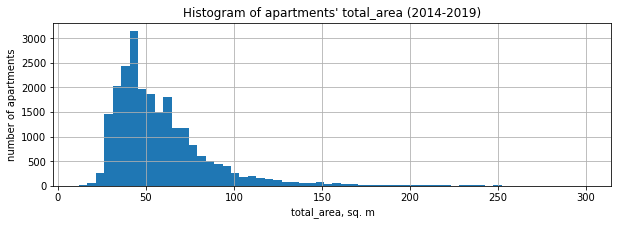

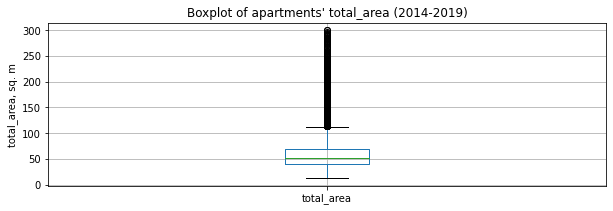

In [73]:
plots_of(df, 'total_area')

Можно сделать следующие наблюдения:
- распределение похоже на распределение Пуассона, что разумно отражает распределение этого параметра;
- основная масса данных смещена в левую область гистограммы. Это означает, что есть значения больше 250 кв. м. Такие значения - явный выброс. Диаграмма размаха это подтверждает.

Напишем функцию, которая для нашего параметра будет искать границы, дальше которых значения можно считать выбросами. Для определения этих границ воспользуемся методикой построения графика "ящик с усами":
- найдём первый и третий квартили - это будет наш "ящик", содержащий 50% всех данных;
- рассчитаем межквартильное расстояние;
- рассчитаем верхнюю и нижнюю границы - размах "усов". В размах «усов» попадают нормальные значения, а за пределами находятся выбросы.

Также наша функция будет выводить количество выбросов и их долю от общего количества данных. И строить графики уже по срезу нормальных значений.

In [74]:
def statistics(df, column):
    Q1 = df[column].quantile(q=0.25) # Найдём границу, ниже которой 25% самых низких значений
    Q2 = df[column].quantile(q=0.5) # Найдём медиану
    Q3 = df[column].quantile(q=0.75) # Найдём границу, выше которой 25% самых высоких значений
    IQR = Q3 - Q1 # Найдём межквартильный размах
    max_correct = Q3 + 1.5 * IQR # Найдём границу, выше которой находятся выбросы
    min_correct = Q1 - 1.5 * IQR # Найдём границу, ниже которой находятся выбросы
    if min_correct < 0: # Если нижняя граница отрицательная, то примем её за 0. 
        min_correct = 0
    outliers_count = df[column].notnull().sum() - len(df[(df[column] <= max_correct) & (df[column] >= min_correct)])
    print('Медианное значение:', Q2)
    print('Нижняя граница нормальных значений:', min_correct)
    print('Верхняя граница нормальных значений:', max_correct)
    print('Количество выбросов:', outliers_count)
    print('Доля выбросов от общего числа данных:', outliers_count / len(df))
    df_filtered = df[(df[column] <= max_correct) & (min_correct <= df[column])] # По границам нормальных значений построим срез
    plots_of(df_filtered, column) # Построим графики по срезу

Найдем медиану, границы нормальных значений, количество и долю выбросов и построим графики по срезу нормальных значений:

Медианное значение: 52.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 112.5
Количество выбросов: 1228
Доля выбросов от общего числа данных: 0.05217539089055065


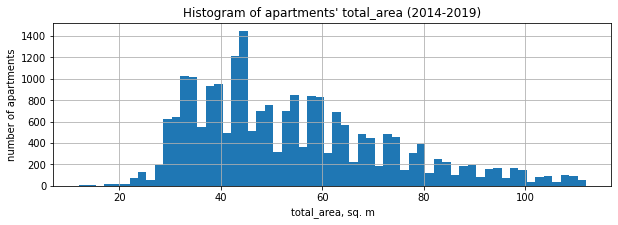

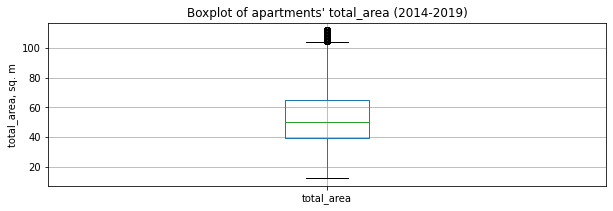

In [75]:
statistics(df, 'total_area')

Количество выбросов около 5%. 
Можно увидеть, что наиболее часто в продаже встречаются квартиры площадью около 45 кв. м. Медиана (зелёная линия на боксплоте) - 52 кв. м.

[В начало](#0)

### <a name="step42"> Цена </a>

Построим гистограмму распределения и диаграмму размаха цен:

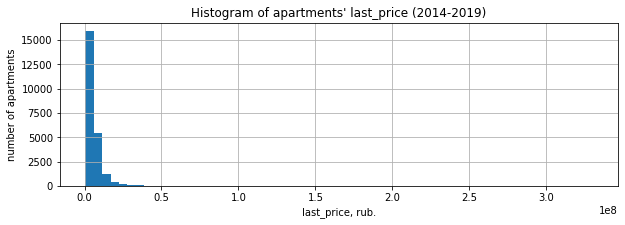

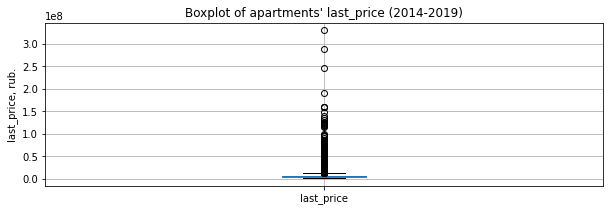

In [76]:
plots_of(df, 'last_price')

Можно сделать следующие наблюдения:
- основная масса данных смещена в левую область гистограммы. Это связано с тем, что есть цены больше 50 млн руб. Такие значения очень редки на рынке и скорее являются выбросами. Диаграмма размаха подтверждает большое количество выбросов: "ящик" сильно сжат и находится внизу диаграммы.

Найдем медиану, границы нормальных значений, количество и долю выбросов и построим графики по срезу нормальных значений:

Медианное значение: 4630000.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 11775000.0
Количество выбросов: 2005
Доля выбросов от общего числа данных: 0.08518864717878993


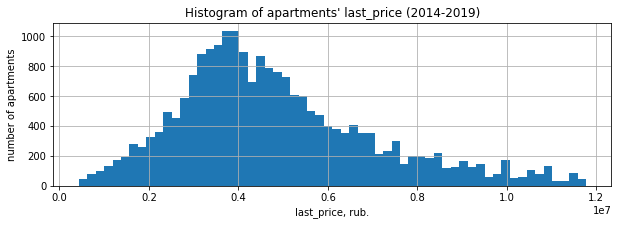

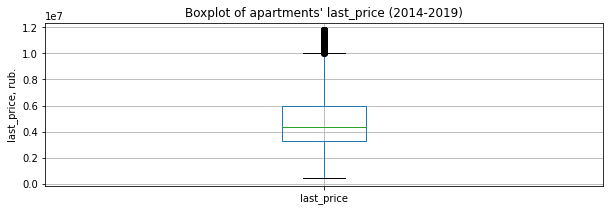

In [77]:
statistics(df, 'last_price')

Количество выбросов около 8,5%. 

Можно увидеть, что распределение похоже на распределение Пуассона, что ожидаемо. Наиболее часто в продаже встречаются квартиры с ценой около 4 млн руб. Медиана (зелёная линия на боксплоте) - 4,6 млн руб.

Сохраним срез данных с нормальными данными по ценам квартир (без выбросов). Будем использовать его в будущем при анализе влияния других параметров на цену.

In [78]:
filtered_price = df.query('last_price <= 11775000.0')

### <a name="step43"> Цена кв. м </a>

Построим гистограмму распределения и диаграмму размаха цены кв. м:

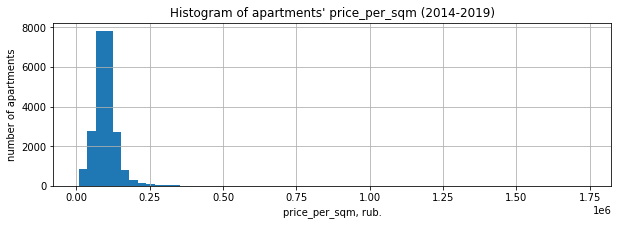

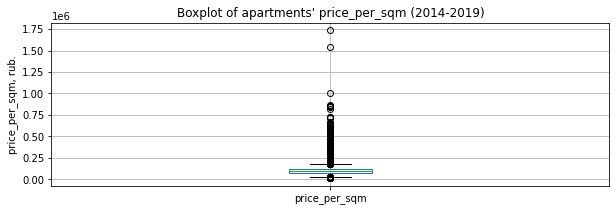

In [79]:
plots_of(df, 'price_per_sqm')

Можно сделать следующие наблюдения:
- распределение похоже на распределение Пуассона, что ожидаемо.
- основная масса данных смещена в левую область гистограммы. Это связано с тем, что есть цена кв. м больше 1.5 млн руб. Такие значения очень редки на рынке и скорее являются выбросами. Диаграмма размаха подтверждает большое количество выбросов: "ящик" сильно сжат и находится внизу диаграммы.

Найдем медиану, границы нормальных значений, количество и долю выбросов и построим графики по срезу нормальных значений:

Медианное значение: 95454.54545454546
Нижняя граница нормальных значений: 20334.494650900902
Верхняя граница нормальных значений: 171514.58098723722
Количество выбросов: 1062
Доля выбросов от общего числа данных: 0.04512236573759348


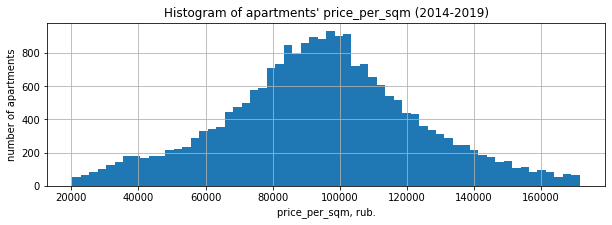

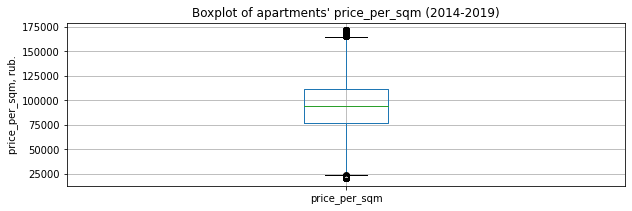

In [80]:
statistics(df, 'price_per_sqm')

Количество выбросов около 4,5%. Наиболее часто в продаже встречаются квартиры с ценой кв. м около 100 тыс. руб. Медиана - 95 тыс. руб.

Сохраним срез данных с нормальными данными по ценам кв. м (без выбросов). Будем использовать его в будущем при анализе влияния других параметров на цену.

In [81]:
filtered_price_per_sqm = df.query('20334.49 <= price_per_sqm <= 171514.58')

[В начало](#0)

### <a name="step44"> Число комнат </a>

Построим гистограмму распределения и диаграмму размаха числа комнат:

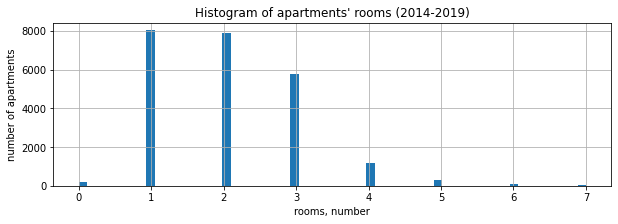

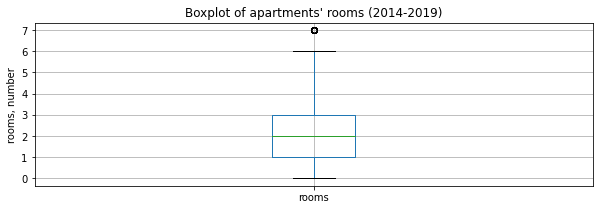

In [82]:
plots_of(df, 'rooms')

Можно сделать следующие наблюдения:
- распределение похоже на распределение Пуассона, что разумно характеризует природу этого параметра;
- количество комнат, равное 7, уже является выбросом - то есть редким явлением.

Найдем медиану, границы нормальных значений, количество и долю выбросов и построим графики по срезу нормальных значений:

Медианное значение: 2.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 6.0
Количество выбросов: 43
Доля выбросов от общего числа данных: 0.001826988443235894


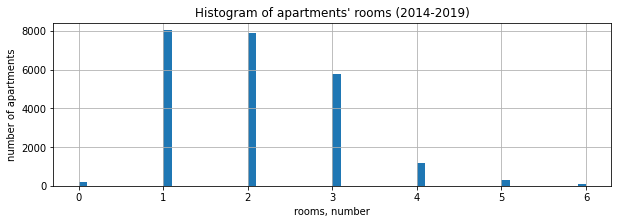

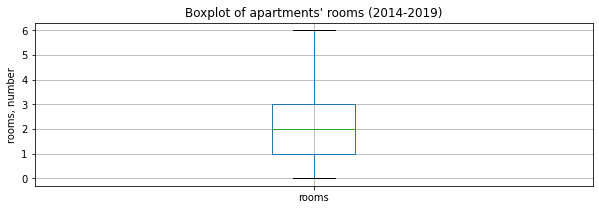

In [83]:
statistics(df, 'rooms')

Количество выбросов около 0,2%. Наиболее часто в продаже встречаются квартиры с 1 и 2 комнатами. Далее по распространенности - трёхкомнатные. Медиана - 2 комнаты.

### <a name="step45"> Высота потолков </a>

Построим гистограмму распределения и диаграмму размаха высоты потолков:

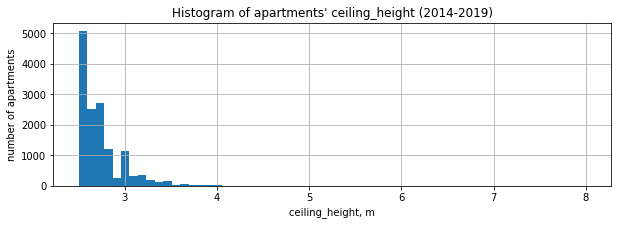

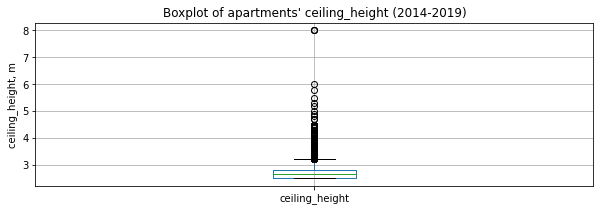

In [84]:
plots_of(df, 'ceiling_height')

Можно сделать следующие наблюдения:
- основная масса данных смещена в левую область гистограммы. Это связано с тем, что есть потолки высотой более 7 м. Такие значения явно выбросы. 

Найдем медиану, границы нормальных значений, количество и долю выбросов и построим графики по срезу нормальных значений:

Медианное значение: 2.65
Нижняя граница нормальных значений: 2.1000000000000005
Верхняя граница нормальных значений: 3.2199999999999998
Количество выбросов: 759
Доля выбросов от общего числа данных: 0.03224847042828008


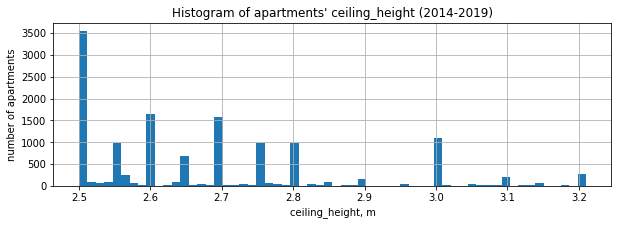

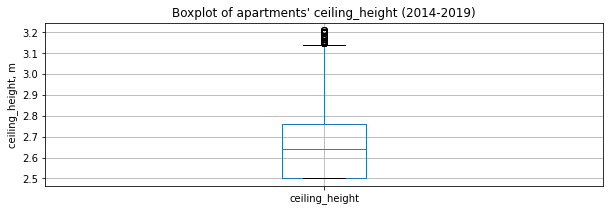

In [85]:
statistics(df, 'ceiling_height')

Количество выбросов около 3%. Наиболее часто в продаже встречаются квартиры с высотой потолков 2,5 м. Медиана - 2,65 м.

[В начало](#0)

### <a name="step46"> Время продажи </a>

Построим гистограмму распределения и диаграмму размаха времени продажи:

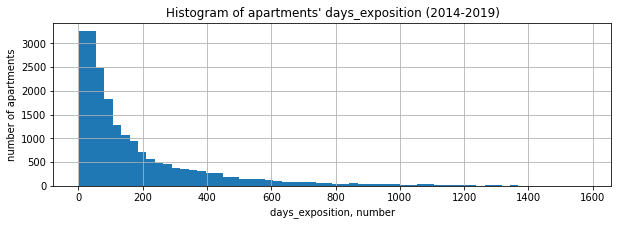

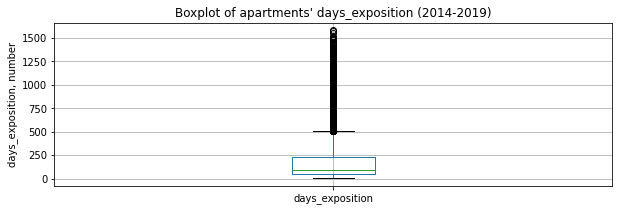

In [86]:
plots_of(df, 'days_exposition')

Можно сделать следующие наблюдения:
- распределение похоже на распределение Пуассона, что разумно отражает природу этого параметра;
- основная масса данных смещена в левую область гистограммы. Это связано с тем, что есть объекты с временем экспозиции более 1400 дней. Такие значения очень редки на рынке и являются выбросами.

Найдем медиану, границы нормальных значений, количество и долю выбросов и построим графики по срезу нормальных значений:

Медианное значение: 95.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 510.0
Количество выбросов: 1664
Доля выбросов от общего числа данных: 0.07070020394289599


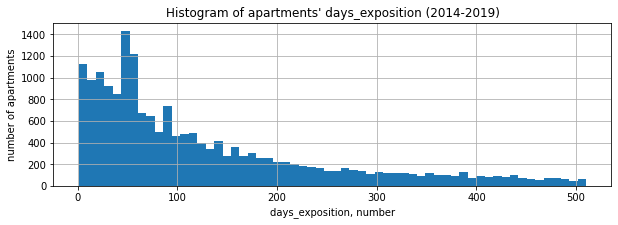

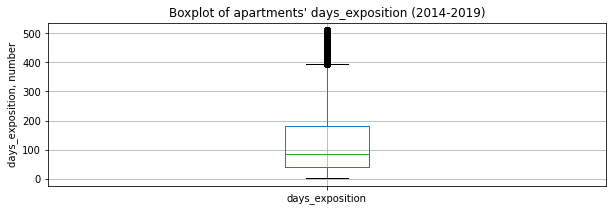

In [87]:
statistics(df, 'days_exposition')

Количество выбросов около 7%. 

Если повысить детализацию гистограммы (увеличить число "корзин") и выбрать диапазон значений до 100 дней, то можно заметить странное явление:

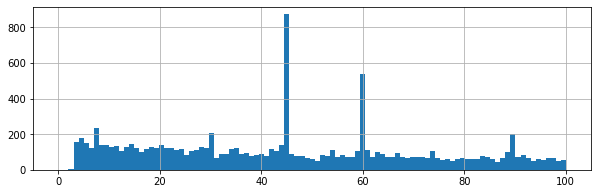

In [88]:
df.query('days_exposition <= 510')['days_exposition'].hist(range=(0, 100), bins=101, figsize=(10, 3))
plt.show()

Есть пики на значениях в 45 и 60 дней. Небольшие пики также можно наблюдать на 30, 75 и 90 днях. Скорее всего это связано с особенностями размещения объектов на портале: например, объявление закрывается автоматически через 15 дней, если его специально не продлить.

Найдём среднее время продажи (без учета выбросов):

In [89]:
df.query('days_exposition <= 510.0')['days_exposition'].describe()

count    18720.000000
mean       128.464904
std        121.218181
min          1.000000
25%         41.000000
50%         85.000000
75%        182.000000
max        510.000000
Name: days_exposition, dtype: float64

Среднее время продажи - 128 дней, медианное время - 95 дней.

Будем считать, что продажи прошли быстро, если время экспозиции составило меньше 2 квартиля - меньше 41 дня. А необычно долго, когда время экспозиции больше 3 квартиля - больше 182 дней.

Изучим факторы, влиящие на стоимость квартир. Узнаем, зависит ли цена от площади, числа комнат, удалённости от центра. Посчитаем коэффициенты корреляции Пирсона. В качестве данных для оценки корреляции будем брать рассчитанные выше срезы нормальных данных.

[В начало](#0)

### <a name="step47"> Влияние площади на цену </a>

Составим срез данных, где нормальные значения в столбце total_area. Срез данных будем делать по таблице, где уже отфильтрованы выбросы по цене:

In [90]:
df_price_area = filtered_price.query('total_area <= 112.5')[['last_price', 'total_area']]

Рассчитаем коэффициент корреляции по срезу данных:

In [91]:
df_price_area['last_price'].corr(df_price_area['total_area'])

0.6913480723801814

Коэффициент корреляции составляет почти 0,7 - это означает, что между ценой и площадью квартиры довольно сильная положительная взаимосвязь. С высокой уверенностью можно ожидать, что чем больше квартира, тем выше её цена.

Построим диаграмму рассеяния: 

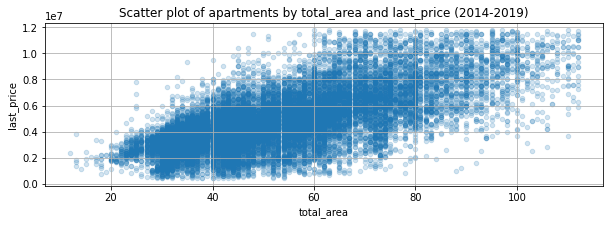

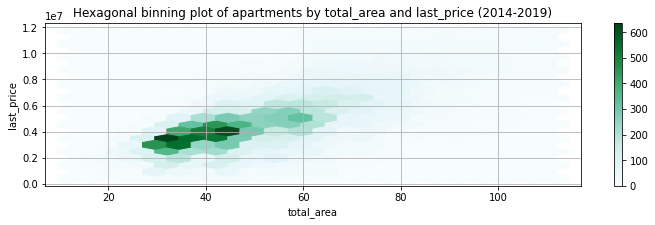

In [92]:
df_price_area.plot(x='total_area', y='last_price', kind='scatter', grid=True, figsize=(10, 3), alpha=0.2)
plt.title(f"Scatter plot of apartments by total_area and last_price (2014-2019)")
plt.show()
df_price_area.plot(x='total_area', y='last_price', kind='hexbin', gridsize=20, figsize=(12, 3), sharex=False, grid=True)
plt.title(f"Hexagonal binning plot of apartments by total_area and last_price (2014-2019)")
plt.show()

Наиболее часто в продаже встречаются квартиры с сочетанием: площадь 30 кв. м и цена 3.5 млн руб.

### <a name="step48"> Влияние числа комнат на цену </a>

Чтобы исключить влияние площади квартиры, будем анализировать влияние числа комнат на стоимость кв. м. В противном случае мы просто выявим взимосвязь, что чем, больше комнат, тем больше цена, так как, как правило, чем больше комнат, тем больше площадь квартиры.

Составим срез данных, где нормальные значения в столбце rooms. Срез данных будем делать по таблице, где уже отфильтрованы выбросы по цене кв. м:

In [93]:
df_price_rooms = filtered_price_per_sqm.query('1 <= rooms <= 6')[['price_per_sqm', 'rooms']]

Рассчитаем коэффициент корреляции по срезу данных:

In [94]:
df_price_rooms['price_per_sqm'].corr(df_price_rooms['rooms'])

-0.10293566899106288

Коэффициент корреляции составляет -0,1 - это означает, что между ценой кв. м и числом комнат практически нет взаимосвязи. Она совсем небольшая и отрицательная. То есть чем больше комнат, тем их дешевле, со скидкой за опт, готовы продавать. Это логично. Но опять же - взаимосвязь крайне низкая.

Построим диаграмму рассеяния:

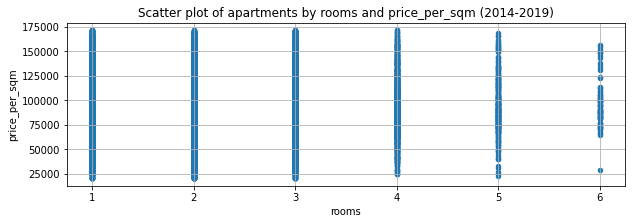

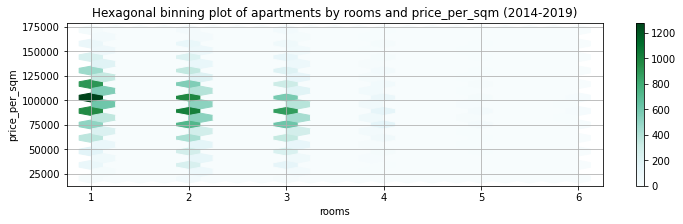

In [95]:
df_price_rooms.plot(x='rooms', y='price_per_sqm', kind='scatter', grid=True, figsize=(10, 3))
plt.title(f"Scatter plot of apartments by rooms and price_per_sqm (2014-2019)")
plt.show()
df_price_rooms.plot(x='rooms', y='price_per_sqm', kind='hexbin', gridsize=20, figsize=(12, 3), sharex=False, grid=True)
plt.title(f"Hexagonal binning plot of apartments by rooms and price_per_sqm (2014-2019)")
plt.show()

Наиболее часто в продаже встречаются квартиры с сочетанием: 1 комната и цена кв. м 100 тыс. руб.

[В начало](#0)

### <a name="step49"> Влияние удалённости от центра на цену </a>

Корректно оценивать влияние удаленности на стоимость квартир мы можем только внутри одного города. Если оценивать корреляцию для нескольких городов одновременно, то будут происходить искажения. Это связано с тем, что дорогие квартиры в центре небольшого города будут считаться дешевыми для центра большого города. Из-за этого взаимосвязь параметров будет "поймана" хуже.

Поэтому считать корреляцию будем для одного города - того, по которому у нас больше всего данных. Найдём этот город:

In [96]:
df['locality_name'].value_counts().head()

Санкт-Петербург    15603
Мурино               590
Кудрово              471
Шушары               440
Всеволожск           397
Name: locality_name, dtype: int64

Ожидаемо, этот город - Санкт-Петербург. 

Определим границы нормальных значений для столбца cityCenters_nearest и построим гистограмму:

Медианное значение: 12524.0
Нижняя граница нормальных значений: 171.0
Верхняя граница нормальных значений: 24019.0
Количество выбросов: 114
Доля выбросов от общего числа данных: 0.007741409751460003


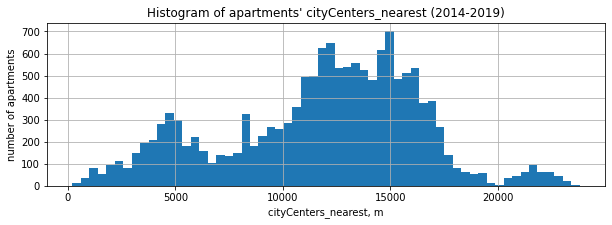

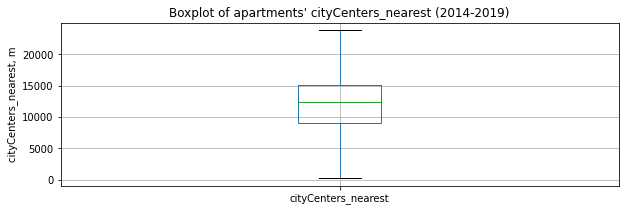

In [97]:
statistics(filtered_price_per_sqm.query('locality_name == "Санкт-Петербург"'), 'cityCenters_nearest')

Можно увидеть провал значений рядом с 20 км. Похоже, что на портале нет квартир, так удаленных от центра Санкт-Петербурга. Можно предположить, что там находится "пояс" из промзон и Невский залив.

Отфильтруем таблицу от выбросов по расстоянию до центра:

In [98]:
df_price_center = (filtered_price_per_sqm.query('171 <= cityCenters_nearest <= 24019 and locality_name == "Санкт-Петербург"')
                   [['price_per_sqm', 'cityCenters_nearest']])

Рассчитаем коэффициент корреляции по срезу данных:

In [99]:
df_price_center['price_per_sqm'].corr(df_price_center['cityCenters_nearest'])

-0.26866519915177506

Корреляция получилась небольшой и отрицательной. Это значит, что есть небольшая взаимосвязь между ценой и близостью к центру. Причем, чем больше расстояние от центра, тем ниже цена. Это разумно: спрос на квартиры в центре выше.

Построим диаграмму рассеяния:

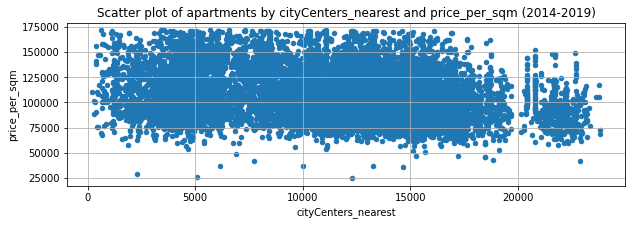

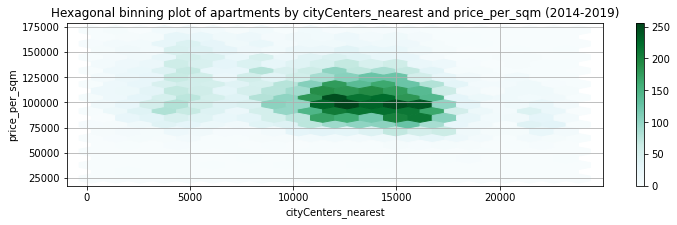

In [100]:
df_price_center.plot(x='cityCenters_nearest', y='price_per_sqm', kind='scatter', grid=True, figsize=(10, 3))
plt.title(f"Scatter plot of apartments by cityCenters_nearest and price_per_sqm (2014-2019)")
plt.show()
df_price_center.plot(x='cityCenters_nearest', y='price_per_sqm', kind='hexbin', gridsize=20, figsize=(12, 3), sharex=False, grid=True)
plt.title(f"Hexagonal binning plot of apartments by cityCenters_nearest and price_per_sqm (2014-2019)")
plt.show()

На диаграмме рассеяния действительно сложно заметить какую-то взамосвязь в данных. Однако видно, что наиболее часто в продаже встречаются квартиры с сочетанием: 12 км от центра и цена кв. м 100 тыс. руб.

### <a name="step410"> Влияние типа этажа на цену </a>

Будем оценивать влияние типа этажа на стоимость квартир как лотов, а не на стоимость кв. м. Интересно посмотреть, где расположены самые дорогие лоты. 

Напишем функцию, которая на вход будет принимать параметр (название столбца) и возвращать таблицу со средними и медианными ценами для значений этого столбца, а также количество значений. Такую функцию удобно использовать для оценки влияния категориальных значений на стоимость квартир.

In [101]:
weekdays = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
# К сожалению, я не могу использовать комбинацию типа df['weekday'].unique(), так как будет нарушена последовательность в списке
floor_types = ['первый', 'другой', 'последний']
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
years = [2014, 2015, 2016, 2017, 2018, 2019]
list_of_types = {'floor_type': floor_types, 'weekday': weekdays, 'month': months, 'year': years}
def price_to(param):
    list_for_df = []
    for type in list_of_types[param]:
        mean = filtered_price[filtered_price[param] == type]['last_price'].mean()
        median = filtered_price[filtered_price[param] == type]['last_price'].median()
        count = filtered_price[filtered_price[param] == type]['last_price'].count()
        list_for_df.append([type, mean, median, count])
    df_price_to = pd.DataFrame(list_for_df, columns=[param, 'mean', 'median', 'count'])
    return df_price_to

Составим таблицу с типами этажей, ценами квартир и количеством объявлений:

In [102]:
price_to_floor = price_to('floor_type')
price_to_floor

,floor_type,mean,median,count
0,первый,4.126041e+06,3800000.0,2790
1,другой,5.028005e+06,4590000.0,15699
2,последний,4.480300e+06,4025000.0,2971


Ожидаемо, квартир на промежуточных (других) этажах больше всего среди объявлений. 

Построим график, чтобы оценить влияние типа этажа на стоимость:

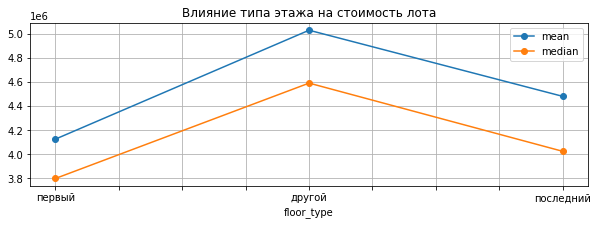

In [103]:
ax = price_to_floor.plot(x='floor_type', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3), 
                    title='Влияние типа этажа на стоимость лота')
plt.show()

Видно, что и средняя, и медианная цена выше для квартир, которые находятся на "промежуточных" этажах. Самые дешёвые квартиры расположены на первом этаже.

[В начало](#0)

### <a name="step411"> Влияние дня недели размещения на цену </a>

Составим таблицу с днями размещения, ценами квартир и количеством объявлений:

In [104]:
price_to_weekday = price_to('weekday')
price_to_weekday

,weekday,mean,median,count
0,понедельник,4.835478e+06,4400000.0,3273
1,вторник,4.884983e+06,4494500.0,3810
2,среда,4.871077e+06,4490000.0,3595
3,четверг,4.845573e+06,4400000.0,3851
4,пятница,4.814477e+06,4355000.0,3664
5,суббота,4.731132e+06,4400000.0,1781
6,воскресенье,4.784114e+06,4400000.0,1557


Построим график с ценами квартир в зависимости от дня размещения:

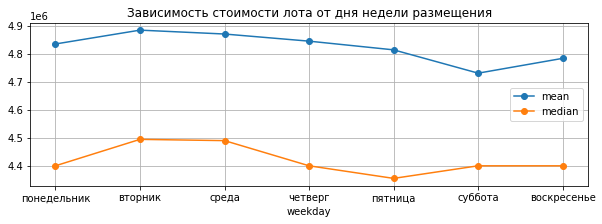

In [105]:
price_to_weekday.plot(x='weekday', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                     title='Зависимость стоимости лота от дня недели размещения')
plt.show()

Самые дорогие квартиры размещают во вторник и среду, а ближе к выходным цена падает, как медианная, так и средняя. Непонятно, связана ли высокая цена в середине недели с бодрым рабочим настроем или просто собственники недорогих квартир имеют больше свободного времени в выходные и тогда размещают объявления.

### <a name="step412"> Влияние месяца размещения на цену </a>

Составим таблицу с месяцами размещения, ценами квартир и количеством объявлений:

In [106]:
price_to_month = price_to('month')
price_to_month

,month,mean,median,count
0,январь,4.805936e+06,4400000.0,1353
1,февраль,4.829814e+06,4400000.0,2402
2,март,4.801615e+06,4400000.0,3509
3,апрель,4.937329e+06,4550000.0,2168
4,май,NaN,NaN,0
5,июнь,4.682171e+06,4200000.0,1612
6,июль,4.842080e+06,4371192.0,1537
7,август,4.836468e+06,4370000.0,1587
8,сентябрь,4.942695e+06,4400000.0,1791
9,октябрь,4.802903e+06,4400000.0,1944


Построим график с ценами квартир в зависимости от месяца размещения:

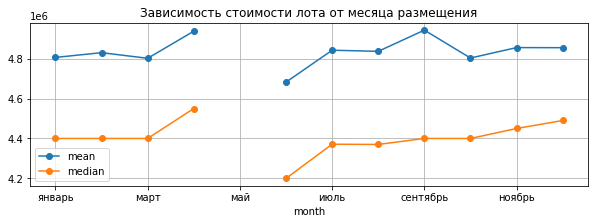

In [107]:
price_to_month.plot(x='month', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                   title='Зависимость стоимости лота от месяца размещения')
plt.show()

Наблюдения:
- нет данных за май - похоже, что они были утеряны при загрузке или выгрузке из БД. Надо сообщить об этом инженерам;
- самые высокие цены на квартиры, которые размещены в апреле, а самые низкие - в июне.

[В начало](#0)

### <a name="step413"> Влияние года размещения на цену </a>

Составим таблицу с годами размещения, ценами квартир и количеством объявлений:

In [108]:
price_to_year = price_to('year')
price_to_year

,year,mean,median,count
0,2014,5.713395e+06,5475000.0,88
1,2015,5.243871e+06,4900000.0,1013
2,2016,4.797366e+06,4300000.0,2507
3,2017,4.760242e+06,4299500.0,7452
4,2018,4.772058e+06,4399000.0,7871
5,2019,5.095913e+06,4800000.0,2600


Построим график с ценами квартир в зависимости от года размещения:

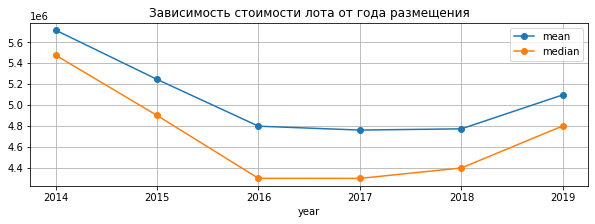

In [109]:
price_to_year.plot(x='year', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                  title='Зависимость стоимости лота от года размещения')
plt.show()

Можно увидеть, что на промежутке 2016-2017 гг. находится "яма" в стоимости - был хороший момент, чтобы купить квартиру. Медианная цена составляла 4,3 млн руб., а средняя - 4,8 млн руб.

За 2014 год было очень мало размещено объявлений. Видимо это начало работы портала. Средняя цена за этот год может отличаться от реальной средней цены на рынке (из-за малого размера выборки).

### <a name="step414"> 10 населённых пунктов с наибольшим числом объявлений </a>

Выберем 10 населённых пунктов с наибольшим числом объявлений:

In [110]:
df['locality_name'].value_counts().head(10)

Санкт-Петербург    15603
Мурино               590
Кудрово              471
Шушары               440
Всеволожск           397
Пушкин               364
Колпино              336
Парголово            326
Гатчина              307
Выборг               235
Name: locality_name, dtype: int64

Сложим в список названия этих населённых пунктов:

In [111]:
top_10_names = dict(df['locality_name'].value_counts().head(10)).keys()
top_10_names

dict_keys(['Санкт-Петербург', 'Мурино', 'Кудрово', 'Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'Парголово', 'Гатчина', 'Выборг'])

Заменим значения в столбце locality_name на "другие", если населенный пункт не входит в топ-10:

In [112]:
df['locality_name'] = df['locality_name'].where(df['locality_name'].isin(top_10_names), 'другие')

Построим круговую диаграмму распределения объявлений по городам:

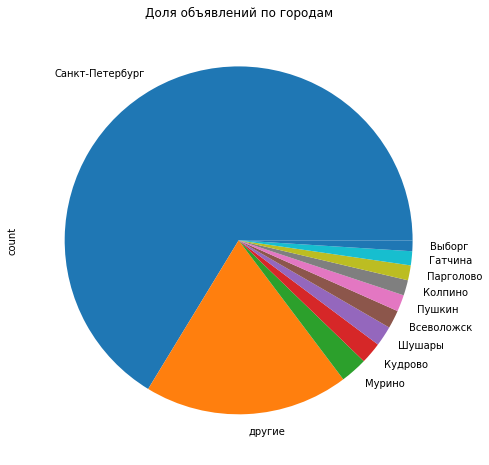

In [113]:
# построим сводную таблицу по городам и посчитаем количество объявлений
df_grouped = df.pivot_table(index='locality_name', values='first_day_exposition', aggfunc=['count'])
# переименуем столбец, чтобы не было мультииндекса
df_grouped.columns = ['count']
# отсортируем таблицу по количеству объявлений
df_grouped = df_grouped.sort_values('count', ascending=False)
# построим круговую диаграмму
df_grouped.plot(y='count', kind='pie', figsize=(8, 8), title='Доля объявлений по городам', legend=False)
plt.show()

На Петербург приходится почти 3/4 всех объявлений. Остальные города в области сильно уступают по количеству объявлений.

Сохраним таблицу со срезом объявлений из топ-10 городов и оценим её размер:

In [114]:
top_10 = df.query('locality_name in @top_10_names')
len(top_10)

19069

Определим границы нормальных значений цены кв. м, чтобы не учитывать выбросы, и оценим гистограмму:

Медианное значение: 101111.11111111111
Нижняя граница нормальных значений: 36278.19444444445
Верхняя граница нормальных значений: 170233.0833333333
Количество выбросов: 932
Доля выбросов от общего числа данных: 0.04887513765797892


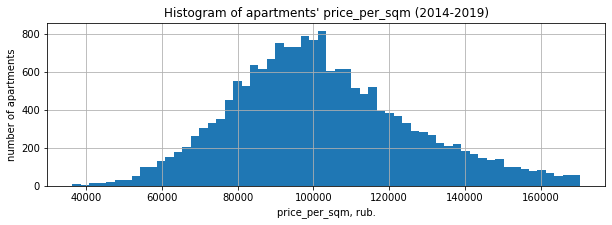

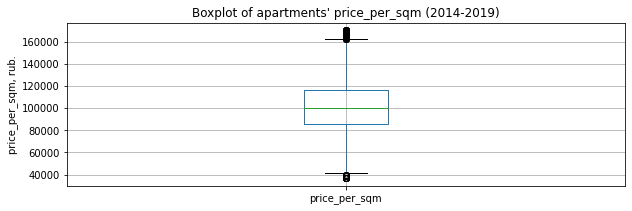

In [115]:
statistics(top_10, 'price_per_sqm')

Возьмём срез данных с нормальными ценами за кв. м:

In [116]:
top_10 = top_10.query('36278 <= price_per_sqm <= 170233')
len(top_10)

18137

Посчитаем среднюю цену квадратного метра в этих населённых пунктах и выведем диаграмму:

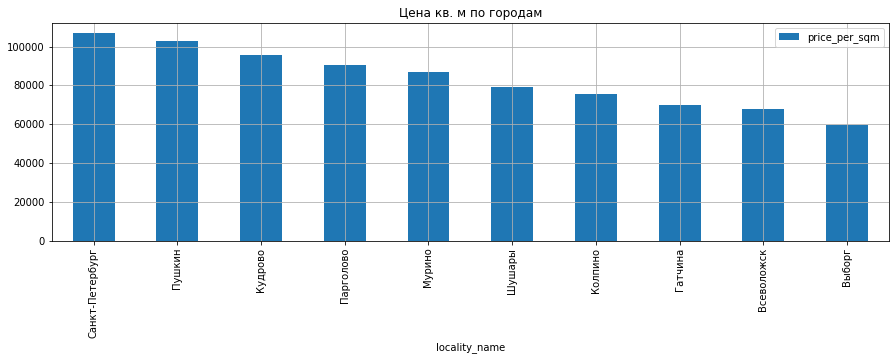

In [117]:
top_10_grouped = (top_10
        .pivot_table(index='locality_name', values='price_per_sqm')
         ) # сгруппируем по топ-10 городам и выведем среднюю цену кв. м
top_10_grouped = top_10_grouped.reset_index() # обновим индексы, теперь в таблице два столбца: названия городов и средняя цена кв. м
top_10_grouped = top_10_grouped.sort_values('price_per_sqm', ascending=False) # отсортируем таблицу по убыванию цены кв. м
top_10_grouped.plot(title='Цена кв. м по городам', x='locality_name', y='price_per_sqm', figsize=(15, 4), kind='bar', grid=True) # построим гистограмму
plt.show()

Ожидаемо, что самая высокой цена кв. м оказалась в Санкт-Петербурге. Она составила примерно 110 000 руб. Пушкин расположился довольно близко к столице области - цена там чуть больше 100 000 руб. Самый дешёвый кв. м из нашего топ-10 городов - в Выборге. Его цена около 60 000 руб.

[В начало](#0)

### <a name="step415"> Определение центра Санкт-Петербурга </a>

Создадим таблицу с объявлениями только из Санкт-Петербурга. Для этого выберем соответствующие строки из таблицы с нормальными значениями цены квадратных метров (её мы задавали выше):

In [118]:
df_spb = df.query('locality_name == "Санкт-Петербург"')

Создадим столбец с расстоянием до центра в километрах и округлим значения в нём до целых чисел: 

In [119]:
df_spb['cityCenters_nearest_km'] = round(df_spb['cityCenters_nearest'] / 1000)

Найдём выбросы в расстоянии до центра и построим гистограмму:

Медианное значение: 12.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 25.5
Количество выбросов: 68
Доля выбросов от общего числа данных: 0.004358136255848234


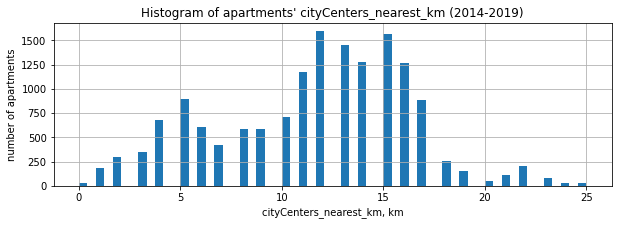

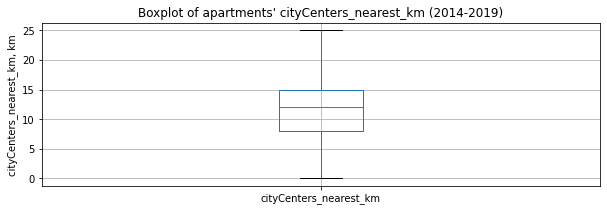

In [120]:
statistics(df_spb, 'cityCenters_nearest_km')

Найдём выбросы в цене кв. м и построим гистограмму:

Медианное значение: 105263.15789473684
Нижняя граница нормальных значений: 40948.27586206895
Верхняя граница нормальных значений: 175431.03448275864
Количество выбросов: 810
Доля выбросов от общего числа данных: 0.051913093635839264


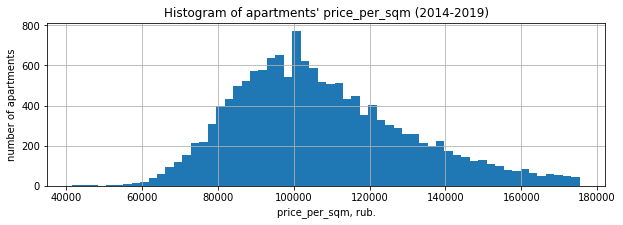

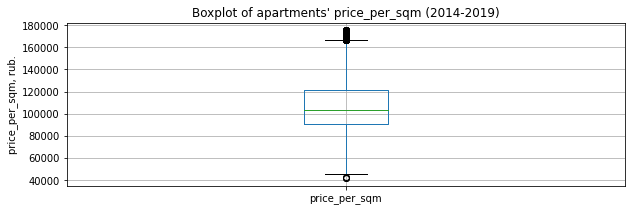

In [121]:
statistics(df_spb, 'price_per_sqm')

Исключим выбросы:

In [122]:
df_spb = df_spb.query('cityCenters_nearest_km <= 25.5 and 40948 <= price_per_sqm <= 175431')

Сгруппируем таблицу по значениям расстояния до центра города и посчитаем среднюю цену кв. м и количество объявлений. Затем построим график зависимости цены кв. м от расстояния до центра города:

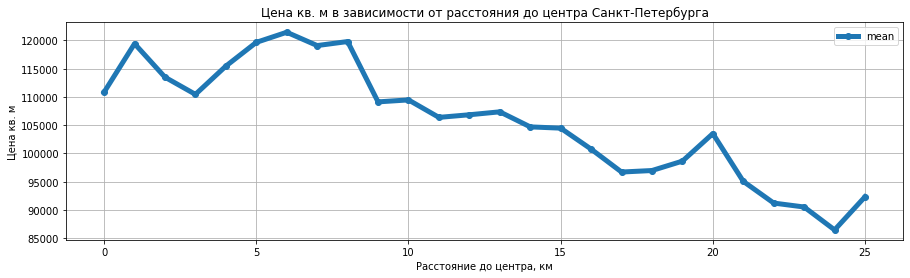

In [123]:
# сгруппируем по километрам и посчитаем среднюю цену
price_to_center_spb = df_spb.pivot_table(index='cityCenters_nearest_km', values='price_per_sqm', 
                                         aggfunc=['mean', 'count']) 
# обновим индексы, чтобы в таблице появилось два столбца: расстояние до центра и цена
price_to_center_spb = price_to_center_spb.reset_index()
# дадим столбцам соответствующие названия
price_to_center_spb.columns = ['cityCenters_nearest_km', 'mean', 'count'] 
# отсортируем таблицу по возрастанию расстояния
price_to_center_spb = price_to_center_spb.sort_values('cityCenters_nearest_km') 
# построим график зависимости цены кв. м от расстояния до центра города
price_to_center_spb.plot(title='Цена кв. м в зависимости от расстояния до центра Санкт-Петербурга', 
                         x='cityCenters_nearest_km', y='mean', style='o-',
                         figsize=(15, 4), grid=True, linewidth=5)
plt.xlabel("Расстояние до центра, км")
plt.ylabel("Цена кв. м")
plt.show()

Можно увидеть небольшой провал цен на расстоянии 3 км от центра, и дальше заметно планомерное падение цены после 8 км. Проверим количество объявлений в зависимости от расстояния до центра. Если на каком-то километре мало объявлений, то цена кв. м в этих объявлениях может искажать реальное среднее значение.

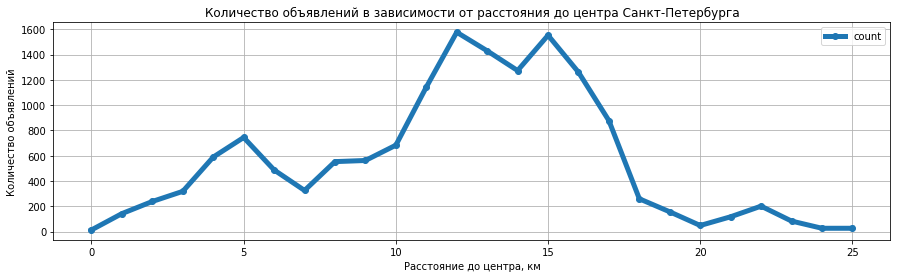

In [124]:
price_to_center_spb.plot(title='Количество объявлений в зависимости от расстояния до центра Санкт-Петербурга', 
                         x='cityCenters_nearest_km', y='count', style='o-',
                         figsize=(15, 4), grid=True, linewidth=5)
plt.xlabel("Расстояние до центра, км")
plt.ylabel("Количество объявлений")
plt.show()

На 3 км есть небольшой провал по количеству объявлений. Однако их число более 200 штук. Будем считать, что среднее значение на этом километре корректное.

Также из графика можно увидеть, что больше всего квартир на километр продаётся на расстоянии между 10 и 17 км от центра.

В качестве центра города определим область с радиусом в 8 км. После этого цены начинают планомерно падать.

[В начало](#0)

### <a name="step416"> Анализ квартир в центре Санкт-Петербурга </a>

Создадим таблицу с квартирами в центре города и посмотрим на её размер:

In [125]:
df_spb_center = df_spb.query('cityCenters_nearest_km <= 8.0')
len(df_spb_center)

3409

Построим гистограммы распределений площади квартир, цены, числа комнат и высоты потолков центра Санкт-Петербурга (выбросы учитывать не будем):

Медианное значение: 72.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 165.5
Количество выбросов: 149
Доля выбросов от общего числа данных: 0.043707832208858904


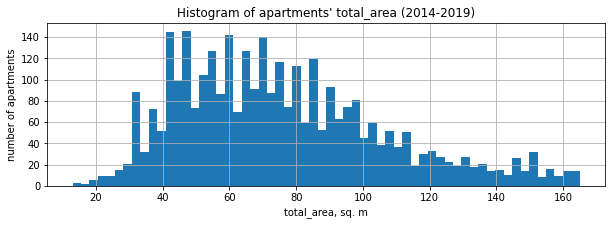

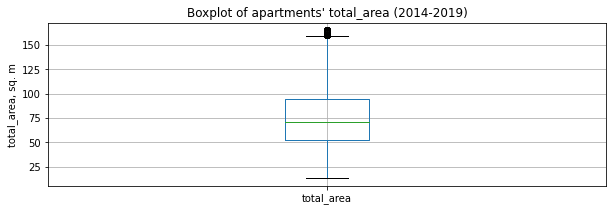

In [126]:
statistics(df_spb_center, 'total_area')

Медианное значение: 8200000.0
Нижняя граница нормальных значений: 0
Верхняя граница нормальных значений: 19425000.0
Количество выбросов: 180
Доля выбросов от общего числа данных: 0.05280140803754767


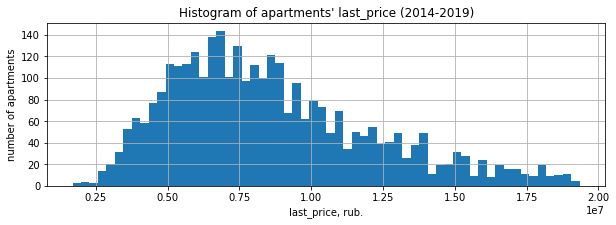

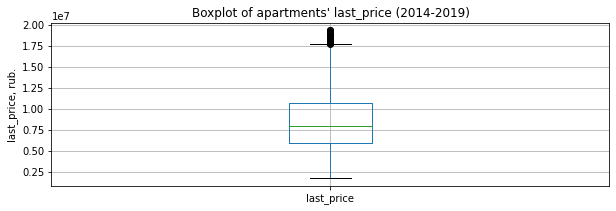

In [127]:
statistics(df_spb_center, 'last_price')

Медианное значение: 3.0
Нижняя граница нормальных значений: 0.5
Верхняя граница нормальных значений: 4.5
Количество выбросов: 290
Доля выбросов от общего числа данных: 0.08506893517160458


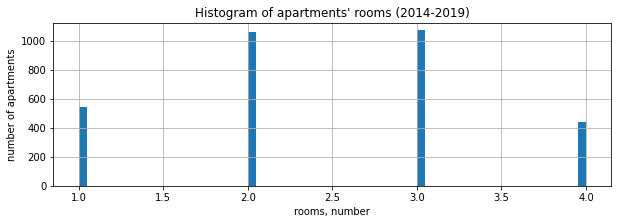

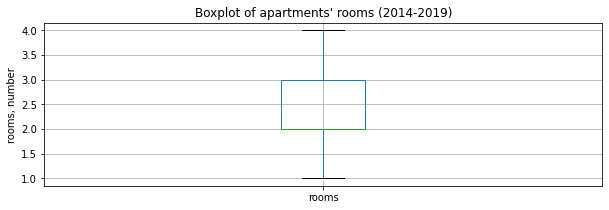

In [128]:
statistics(df_spb_center, 'rooms')

Медианное значение: 3.0
Нижняя граница нормальных значений: 2.099999999999999
Верхняя граница нормальных значений: 3.8600000000000008
Количество выбросов: 56
Доля выбросов от общего числа данных: 0.01642710472279261


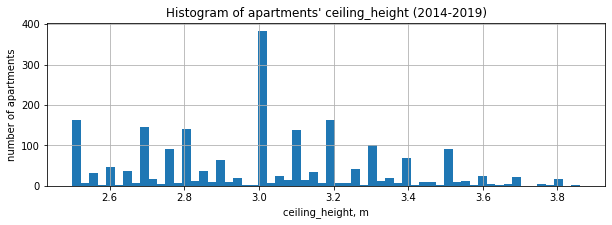

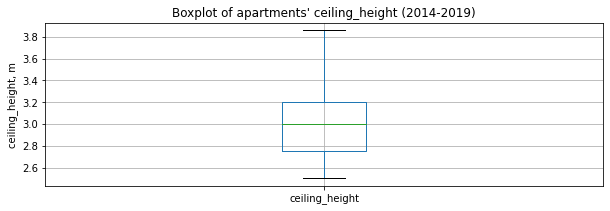

In [129]:
statistics(df_spb_center, 'ceiling_height')

По гистограммам можно сделать вывод, что в центре Санкт-Петербурга наиболее часто встречаются квартиры:
- площадью от 40 до 80 кв. м;
- стоимостью от 5 до 7,5 млн руб.;
- с 2 и 3 комнатами;
- с высотой потолков около 3 м.

Выделим факторы, которые влияют на стоимость квартир в центре столицы области.

Изучим влияние расстояния до центра города на стоимость лотов квартир:

In [130]:
df_spb_center_filtered = df_spb_center.query('last_price < 19425000')
df_spb_center_filtered['last_price'].corr(df_spb_center_filtered['cityCenters_nearest_km'])

-0.18712785415459599

Корреляция получилась небольшой и отрицательной. Это значит, что есть небольшая взаимосвязь между ценой и близостью к центру. Причем, чем больше расстояние от центра, тем ниже цена. 

Построим диаграмму рассеяния:

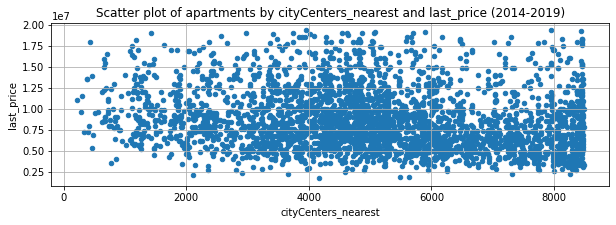

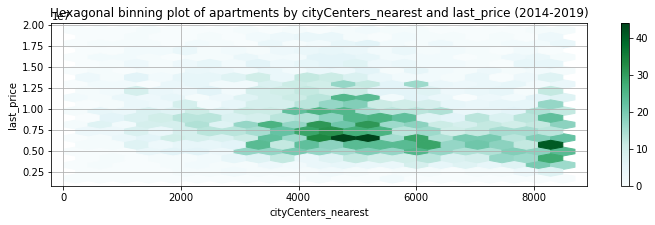

In [131]:
df_spb_center_filtered.plot(x='cityCenters_nearest', y='last_price', kind='scatter', grid=True, figsize=(10, 3))
plt.title(f"Scatter plot of apartments by cityCenters_nearest and last_price (2014-2019)")
plt.show()
df_spb_center_filtered.plot(x='cityCenters_nearest', y='last_price', kind='hexbin', gridsize=20, figsize=(12, 3), sharex=False, grid=True)
plt.title(f"Hexagonal binning plot of apartments by cityCenters_nearest and last_price (2014-2019)")
plt.show()

На диаграмме рассеяния сложно увидеть корреляцию. Зато можно увидеть, что всего в центре города встречаются квартиры с комбинацией параметров: расстояние до центра 5 км и цена около 6,5 млн руб.

Построим графики зависимости цены квартир от типа этажа, дня недели, месяца и года размещения объявления:

In [132]:
weekdays = ['понедельник', 'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'воскресенье']
# К сожалению, я не могу использовать комбинацию типа df['weekday'].unique(), так как будет нарушена последовательность в списке
floor_types = ['первый', 'другой', 'последний']
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
years = [2014, 2015, 2016, 2017, 2018, 2019]
list_of_types = {'floor_type': floor_types, 'weekday': weekdays, 'month': months, 'year': years}
def price_to_spb(param):
    list_for_df = []
    for type in list_of_types[param]:
        mean = df_spb_center_filtered[df_spb_center_filtered[param] == type]['last_price'].mean()
        median = df_spb_center_filtered[df_spb_center_filtered[param] == type]['last_price'].median()
        list_for_df.append([type, mean, median])
    df_price_to_spb = pd.DataFrame(list_for_df, columns=[param, 'mean', 'median'])
    return df_price_to_spb

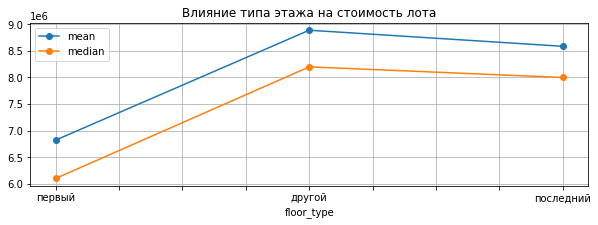

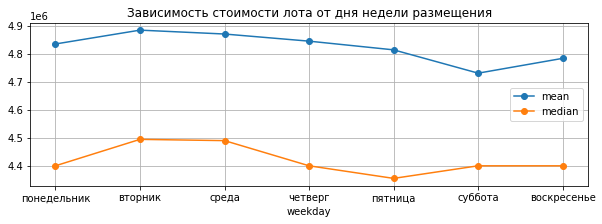

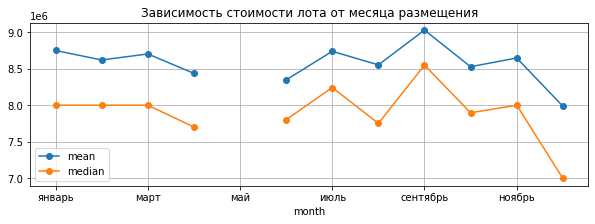

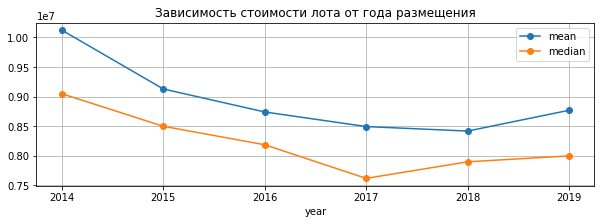

In [133]:
price_to_floor_spb = price_to_spb('floor_type')
price_to_floor_spb.plot(x='floor_type', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                       title='Влияние типа этажа на стоимость лота')
plt.show()
price_to_weekday_spb = price_to_spb('weekday')
price_to_weekday.plot(x='weekday', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                     title='Зависимость стоимости лота от дня недели размещения')
plt.show()
price_to_month_spb = price_to_spb('month')
price_to_month_spb.plot(x='month', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                       title='Зависимость стоимости лота от месяца размещения')
plt.show()
price_to_year_spb = price_to_spb('year')
price_to_year_spb.plot(x='year', y=['mean', 'median'], style='o-', grid=True, figsize=(10, 3),
                      title='Зависимость стоимости лота от года размещения')
plt.show()

По графикам можно сделать выводы, что среди квартир в центре Санкт-Петербурга:
- самые дорогие лоты встречаются на промежуточных этажах, самые дешевые - на первом;
- самые дорогие лоты резмещают во вторник и среду, а ближе к выходным - более дешёвые;
- самые дорогие лоты резмещают в сентябре, а самые дешёвые - в декабре;
- самые дешёвые были проданы в 2017 году - покупателям повезло, они купили в удачный момент.

## <a name="step5"> Общий вывод </a>

В ходе исследования мы провели анализ рынка жилой недвижимости Санкт-Петербурга и прилегающих населённых пунктов. На основе изученных данных были сделаны следующие выводы:
- наиболее типичные квартиры среди всех объявлений имеют следующие параметры: площадь 40-45 кв. м, цена около 4 млн руб., 1 или 2 комнаты.
- квартиры, которые находятся на "промежуточных" этажах, стоят дороже, чем квартиры на первом и последнем этажах. Самые дешёвые квартиры расположены на первом этаже.
- медианное время продажи - 85 дней. Продажа прошла быстро, если время экспозиции составило меньше 41 дня, а долго, если больше 182 дней.
- самая высокая средняя цена кв. м среди городов области - в Санкт-Петербурге. Она составила 110 тыс. руб. Пушкин расположился довольно близко к столице области - цена там чуть больше 100 тыс. руб. Самый дешёвый кв. м в Выборге - 60 тыс. руб.
- наиболее часто встречающаяся высота потолков среди объявлений - 2,5 м, при этом в центре Петербурга - 3 м. 
- на Петербург приходится почти 3/4 всех объявлений. Остальные города в области сильно уступают по количеству объявлений.
- в качестве центра Санкт-Петербурга можно считать область с радиусом в 8 км. За этой областью цены начинают планомерно снижаться - чем дальше от центра, тем сильнее.
- 2017 год был лучшим годом для покупки квартиры в центре Санкт-Петербурга за последние 6 лет: медианная цена лота тогда была самой низкой и составляла менее 8 млн руб.
- на расстоянии 20 км от центра Санкт-Петербурга практически нет квартир в продаже. Скорее всего на таком радиусе от центра находится "пояс" из промзон и Невский залив.
- в данных мы обнаружили взаимосвязь цены квартиры и её площади, а также цены и удаленности от центра. Это ожидаемая корреляция, которая косвенно подтверждает достоверность наших данных.
- самые дорогие квартиры размещают во вторник и среду, а ближе к выходным цена падает. Непонятно, связана ли высокая цена в середине недели с бодрым рабочим настроем или просто собственники недорогих квартир имеют больше свободного времени в выходные и тогда размещают объявления.

Также выявили следующие ошибки в данных и особенности, о которых следует сообщить инженерам:
- нет значений за май - скорее всего они были утеряны в ходе выгрузки из БД.
- в параметрах, которые заполняются автоматически (связаны с геопозицией квартиры) встречается разное количество пропусков. Это означает, что данные были утеряны хаотичным образом при выгрузке из БД.
- заметно влияние особенностей портала на время экспозиции объявлений: встречаются пики в числе дней размещения в 30, 45, 60, 75 и 90 дней. Надо подумать, можно ли "сгладить" это распределение, чтобы можно было корректнее оценивать время продажи.

[В начало](#0)